### Dependencies

In [1]:
import os
import cv2
import math
import random
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import albumentations as albu
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import backend as K
from keras.utils import Sequence
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

!pip install segmentation-models
import segmentation_models as sm

Using TensorFlow backend.


     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')
print('Number of train samples:', train.shape[0])
print('Number of test samples:', submission.shape[0])

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

train_pivoted = pd.pivot_table(train, index=['image'], values=['EncodedPixels'], columns=['label'], aggfunc=np.min).reset_index()
train_pivoted.columns = ['image', 'Fish', 'Flower', 'Gravel', 'Sugar']
display(train_pivoted.head())

Number of train samples: 22184
Number of test samples: 14792


,image,Fish,Flower,Gravel,Sugar
0,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN
1,002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...
2,0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...
3,0035239.jpg,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN
4,003994e.jpg,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...


### Split train and validation sets

In [3]:
X_train, X_val = train_test_split(train_pivoted, test_size=0.2, random_state=seed)
X_train['set'] = 'train'
X_val['set'] = 'validation'
test['set'] = 'test'
print('Number of train samples:', X_train.shape[0])
print('Number of validation samples:', X_val.shape[0])

Number of train samples: 4436
Number of validation samples: 1110


# Model parameters

In [4]:
model_path = '../working/uNet_ResNet34_baseline.h5'
BACKBONE = 'resnet34'
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-4
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = train['label'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
LR_WARMUP_EPOCHS = 3
WARMUP_BATCHES = (LR_WARMUP_EPOCHS * len(X_train)) // BATCH_SIZE

In [5]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    mask = np.zeros( width*height ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def dice_coefficient(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)
    intersection = np.logical_and(img1, img2)
    return 2. * intersection.sum() / (img1.sum() + img2.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def post_process(probability, threshold=0.5, min_size=10000):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros(probability.shape, np.float32)
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
    return predictions

def preprocess_image(image_id, base_path, save_path, HEIGHT=HEIGHT, WIDTH=WIDTH):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    cv2.imwrite(save_path + image_id, image)
        
def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH):
    df = df.reset_index()
    for i in range(df.shape[0]):
        item = df.iloc[i]
        image_id = item['image']
        item_set = item['set']
        if item_set == 'train':
            preprocess_image(image_id, train_base_path, train_images_dest_path)
        if item_set == 'validation':
            preprocess_image(image_id, train_base_path, validation_images_dest_path)
        if item_set == 'test':
            preprocess_image(image_id, test_base_path, test_images_dest_path)
            
def get_metrics(model, df, generator, set_name='Complete set'):
    generator.shuffle = False
    generator.augment = None
    generator.batch_size = 1
    column_names = ['Fish', 'Flower', 'Gravel', 'Sugar', set_name]
    index_name = ['Dice Coeff']
    dice = []
    dice_post = []
    
    for sample in range(len(df)):
        x, y = generator.__getitem__(sample)
        preds = model.predict(x)[0]
        sample_dice = []
        sample_dice_post = []
        for class_index in range(N_CLASSES):
            label_mask = y[..., class_index]
            pred_mask = preds[..., class_index]
            class_dice = dice_coefficient(pred_mask, label_mask)
            pred_mask_post = post_process(pred_mask)
            class_dice_post = dice_coefficient(pred_mask_post, label_mask)
            if math.isnan(class_dice_post):
                class_dice_post = 0.0
            sample_dice.append(class_dice)
            sample_dice_post.append(class_dice_post)
        dice.append(sample_dice)
        dice_post.append(sample_dice_post)

    dice_class = np.mean(dice, axis=0)
    dice = np.mean(dice_class, axis=0)
    metrics = np.append(dice_class,  dice)
    metrics = pd.DataFrame(metrics.reshape(1, metrics.shape[0]), columns=column_names, index=index_name)
    
    dice_class_post = np.mean(dice_post, axis=0)
    dice_post = np.mean(dice_class_post, axis=0)
    metrics_post = np.append(dice_class_post, dice_post)
    metrics_post = pd.DataFrame(metrics_post.reshape(1, metrics_post.shape[0]), columns=column_names, index=index_name)
    
    return metrics, metrics_post

def plot_metrics(history):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', figsize=(20, 14))
    
    ax1.plot(history['loss'], label='Train loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')

    ax2.plot(history['dice_coef'], label='Train Dice coefficient')
    ax2.plot(history['val_dice_coef'], label='Validation Dice coefficient')
    ax2.legend(loc='best')
    ax2.set_title('Dice coefficient')

    ax3.plot(history['score'], label='Train F-Score')
    ax3.plot(history['val_score'], label='Validation F-Score')
    ax3.legend(loc='best')
    ax3.set_title('F-Score')

    plt.xlabel('Epochs')
    sns.despine()
    plt.show()
    

class WarmUpLearningRateScheduler(Callback):
    def __init__(self, warmup_batches, init_lr, verbose=0):
        """
        Constructor for warmup learning rate scheduler
        :param warmup_batches {int}: Number of batch for warmup.
        :param init_lr {float}: Learning rate after warmup.
        :param verbose {int}: 0: quiet, 1: update messages. (default: {0})
        """
        super(WarmUpLearningRateScheduler, self).__init__()
        self.warmup_batches = warmup_batches
        self.init_lr = init_lr
        self.verbose = verbose
        self.batch_count = 0
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.batch_count = self.batch_count + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        if self.batch_count <= self.warmup_batches:
            lr = self.batch_count * self.init_lr / self.warmup_batches
            K.set_value(self.model.optimizer.lr, lr)
            if self.verbose > 0:
                print('\nBatch %02d: WarmUpLearningRateScheduler setting learning rate to %s.' % (self.batch_count + 1, lr))

# Pre-process data

In [6]:
train_base_path = '../input/understanding_cloud_organization/train_images/'
test_base_path = '../input/understanding_cloud_organization/test_images/'
train_images_dest_path = 'base_dir/train_images/'
validation_images_dest_path = 'base_dir/validation_images/'
test_images_dest_path = 'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_images_dest_path)
os.makedirs(validation_images_dest_path)
os.makedirs(test_images_dest_path)

n_cpu = mp.cpu_count()
train_n_cnt = X_train.shape[0]//n_cpu
val_n_cnt = X_val.shape[0]//n_cpu
test_n_cnt = test.shape[0]//n_cpu

# Pre-procecss train set
pool = mp.Pool(n_cpu)
dfs = [X_train.iloc[train_n_cnt*i:train_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = X_train.iloc[train_n_cnt*(n_cpu-1):]
res = pool.map(preprocess_data, [x_df for x_df in dfs])
pool.close()

# Pre-procecss validation set
pool = mp.Pool(n_cpu)
dfs = [X_val.iloc[val_n_cnt*i:val_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = X_val.iloc[val_n_cnt*(n_cpu-1):]
res = pool.map(preprocess_data, [x_df for x_df in dfs])
pool.close()

# Pre-procecss test set
pool = mp.Pool(n_cpu)
dfs = [test.iloc[test_n_cnt*i:test_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = test.iloc[test_n_cnt*(n_cpu-1):]
res = pool.map(preprocess_data, [x_df for x_df in dfs])
pool.close()

In [7]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5)
                            ])

### Data generator

In [8]:
class DataGenerator(Sequence):
    def __init__(self, df, target_df=None, mode='fit', base_path=train_images_dest_path,
                 batch_size=BATCH_SIZE, n_channels=CHANNELS, reshape=(HEIGHT, WIDTH), 
                 n_classes=N_CLASSES, random_state=seed, shuffle=True, preprocessing=None, augmentation=None):
        
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.reshape = reshape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.list_IDs = self.df.index
        self.random_state = random_state
        self.mask_shape = (1400, 2100)
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            Y = self.__generate_y(list_IDs_batch)
            
            if self.augmentation:
                X, Y = self.__augment_batch(X, Y)
            
            return X, Y
        
        elif self.mode == 'predict':
            return X
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['image'].loc[ID]
            img_path = self.base_path + im_name
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.preprocessing:
                img = self.preprocessing(img)
                
#             img = img.astype(np.float32) / 255.
            
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        Y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['image'].loc[ID]
            image_df = self.target_df[self.target_df['image'] == im_name]
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.mask_shape, reshape=self.reshape)
            Y[i, ] = masks

        return Y
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch
    
    def __random_transform(self, img, masks):
        composed = self.augmentation(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
train_generator = DataGenerator(
                  base_path=train_images_dest_path,
                  df=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  reshape=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  random_state=seed)

valid_generator = DataGenerator(
                  base_path=validation_images_dest_path,
                  df=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  reshape=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  random_state=seed)

# Model

In [9]:
model = sm.Unet(encoder_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
warmup_lr = WarmUpLearningRateScheduler(WARMUP_BATCHES, LEARNING_RATE)

loss = sm.losses.bce_dice_loss
metric_list = [dice_coef, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop, warmup_lr]
optimizer = optimizers.Adam(lr=LEARNING_RATE)

model.compile(optimizer=optimizer, loss=loss, metrics=metric_list)
model.summary()

58892288/58889256 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 240, 64) 0           block1_conv2[0][0]               
____________________________________________

In [10]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/15
 - 316s - loss: 1.5810 - dice_coef: 0.2365 - score: 0.1802 - val_loss: 1.5348 - val_dice_coef: 0.2458 - val_score: 0.1865
Epoch 2/15
 - 299s - loss: 1.4598 - dice_coef: 0.2410 - score: 0.1785 - val_loss: 1.4557 - val_dice_coef: 0.2517 - val_score: 0.1882
Epoch 3/15
 - 301s - loss: 1.3517 - dice_coef: 0.2462 - score: 0.1751 - val_loss: 1.3429 - val_dice_coef: 0.2592 - val_score: 0.1866
Epoch 4/15
 - 304s - loss: 1.2695 - dice_coef: 0.2590 - score: 0.1754 - val_loss: 1.2859 - val_dice_coef: 0.2475 - val_score: 0.1700
Epoch 5/15
 - 298s - loss: 1.1938 - dice_coef: 0.3087 - score: 0.1948 - val_loss: 1.3107 - val_dice_coef: 0.2238 - val_score: 0.1500
Epoch 6/15
 - 298s - loss: 1.1351 - dice_coef: 0.3617 - score: 0.2156 - val_loss: 1.2666 - val_dice_coef: 0.2327 - val_score: 0.1486
Epoch 7/15
 - 298s - loss: 1.1110 - dice_coef: 0.3855 - score: 0.2250 - val_loss: 1.2210 - val_dice_coef: 0.2612 - val_score: 0.1571
Epoch 8/15
 - 299s - loss: 1.0977 - dice_coef: 0.3996 - score: 0.2312

## Model loss graph

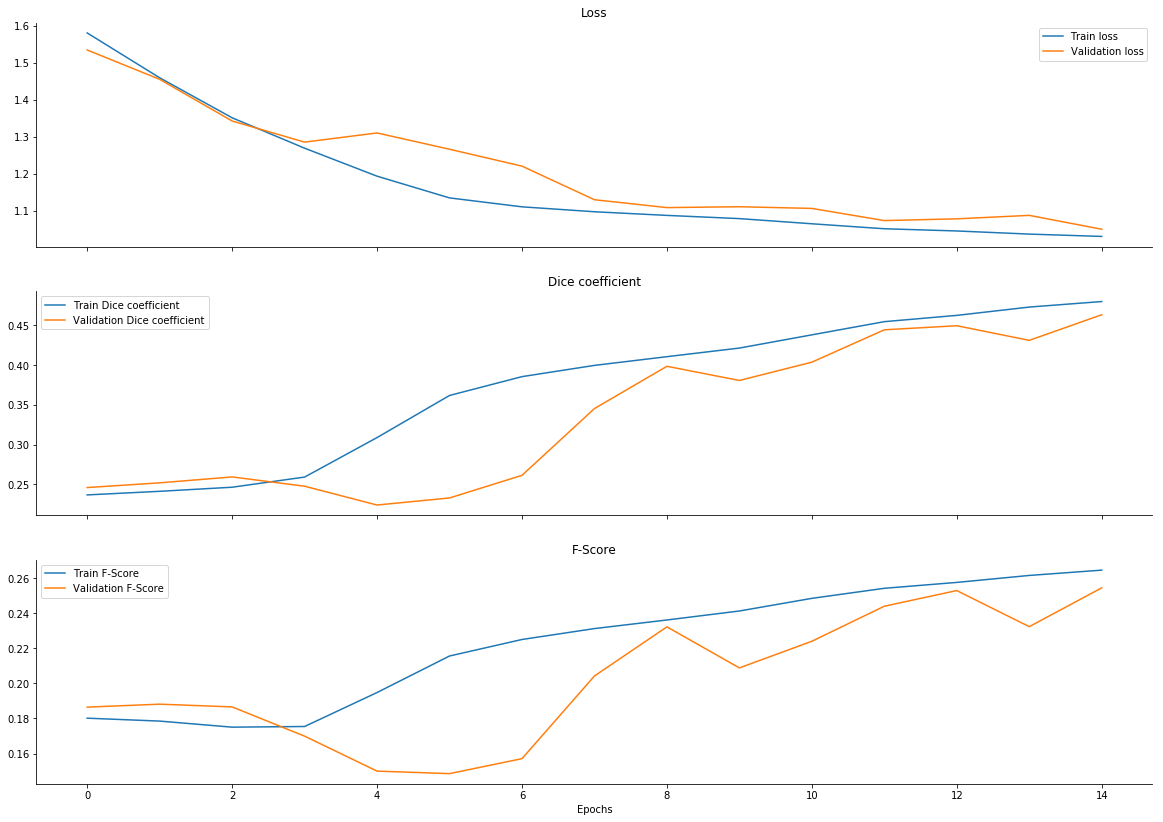

In [11]:
plot_metrics(history)

# Model evaluation

## Without post processing

In [12]:
# Train metrics
train_metrics, train_metrics_post = get_metrics(model, X_train, train_generator, 'Train')
display(train_metrics)

# Validation metrics
validation_metrics, validation_metrics_post = get_metrics(model, X_val, valid_generator, 'Validation')
display(validation_metrics)

,Fish,Flower,Gravel,Sugar,Train
Dice Coeff,0.212779,0.19617,0.217646,0.248285,0.21872


,Fish,Flower,Gravel,Sugar,Validation
Dice Coeff,0.221951,0.194196,0.22344,0.25159,0.222794


## With post processing

In [13]:
display(train_metrics_post)
display(validation_metrics_post)

,Fish,Flower,Gravel,Sugar,Train
Dice Coeff,0.179015,0.246519,0.179264,0.375385,0.245046


,Fish,Flower,Gravel,Sugar,Validation
Dice Coeff,0.180515,0.228757,0.188855,0.368134,0.241565


# Apply model to test set

In [14]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      base_path=test_images_dest_path,
                      df=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      reshape=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      random_state=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for k in range(pred_masks_post.shape[-1]):
            pred_mask = pred_masks_post[...,k]
            pred_mask = post_process(pred_mask)
            pred_masks_post[...,k] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###

        test_df.append(image_df)

sub_df = pd.concat(test_df)

### Regular submission

In [15]:
submission_df = sub_df[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1330 2 1335 1 1344 1 1429 2 1455 1 1458 2 1464...
3,002f507.jpg_Sugar,1099 3 1171 7 1186 1 1443 11 1486 1 1489 8 150...
4,0035ae9.jpg_Fish,70780 5 71130 7 71480 7 71834 3 74309 2 74631 ...


### Submission with post processing

In [16]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1330 2 1335 1 1344 1 1429 2 1455 1 1458 2 1464...
3,002f507.jpg_Sugar,1099 3 1171 7 1186 1 1443 11 1486 1 1489 8 150...
4,0035ae9.jpg_Fish,74309 2 74631 5 74659 2 74960 1 74979 1 74982 ...


In [17]:
# Cleaning created directories
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)